In [1]:
import os
directory = os.getcwd()  
directory = directory.split('src')
path = directory[0]
%cd $path
%pwd

c:\Users\JENMOSQU\Documents\PERSONAL\TESIS\Probabilistic-Electricity-Demand-


'c:\\Users\\JENMOSQU\\Documents\\PERSONAL\\TESIS\\Probabilistic-Electricity-Demand-'

In [2]:
# Libraries utilities
# ==============================================================================

from collections import Counter
from tqdm import tqdm
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

#Model
# ==============================================================================
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from skforecast.model_selection import grid_search_forecaster

from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt


#ARDRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy import stats

#Modules from repo
from src.Utilities import utilities as tool
from src.Utilities import days_creation as days_tool

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
# Configuración options.display
# ==============================================================================
pd.set_option('display.max_rows', 5000)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000
pd.options.display.max_colwidth = 5000
pd.options.display.max_dir_items = 5000
pd.options.display.width = 5000
pd.options.display.float_format = '{:.1f}'.format

In [16]:
days_tool.Especificacion_dias()

In [4]:
df = pd.read_parquet('df_dayli.parquet')
print(df.describe())

df.head()


df.reset_index(inplace=True)
df = df.set_index('Fecha')
df.drop(columns={'index'}, inplace=True)
print(df.info())

                     Fecha     demanda   prep   temp
count                 8460      8460.0 8460.0 8460.0
mean   2011-07-31 12:00:00 160059072.4    6.0   22.4
min    2000-01-01 00:00:00  86794068.3    0.2   20.2
25%    2005-10-15 18:00:00 133692621.4    3.5   22.0
50%    2011-07-31 12:00:00 158386417.5    5.4   22.4
75%    2017-05-15 06:00:00 185625904.6    8.0   22.8
max    2023-02-28 00:00:00 228621213.2   23.0   24.7
std                    NaN  30598883.4    3.4    0.6
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8460 entries, 2000-01-01 to 2023-02-28
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   demanda  8460 non-null   float64
 1   prep     8460 non-null   float64
 2   temp     8460 non-null   float64
dtypes: float64(3)
memory usage: 264.4 KB
None


In [5]:
import pandas as pd
from datetime import date
import holidays

df = pd.DataFrame(df, index=pd.to_datetime(df.index))

# Define el país para obtener los días festivos
pais = 'CO'  # Código para Colombia

# Obtiene los días festivos
festivos = holidays.CountryHoliday(pais)

# Crea una columna 'es_festivo' y marca los días festivos
df['es_festivo'] = df.index.to_series().apply(lambda x: x in festivos)

df

,demanda,prep,temp,es_festivo
Fecha,,,,
2000-01-01,88141869.6,2.6,22.3,True
2000-01-02,89124366.9,2.8,22.1,False
2000-01-03,106186254.6,3.8,21.9,False
2000-01-04,109554603.1,4.0,21.6,False
2000-01-05,109348213.2,3.5,21.5,False
...,...,...,...,...
2023-02-24,220102902.2,1.2,22.3,False
2023-02-25,210862579.0,0.6,22.6,False
2023-02-26,192364075.9,1.5,22.6,False


In [6]:
#df[df['es_festivo'] == True]
df.reset_index(inplace=True)

In [6]:
df

,Fecha,demanda,prep,temp,es_festivo
0,2000-01-01,88141869.6,2.6,22.3,True
1,2000-01-02,89124366.9,2.8,22.1,False
2,2000-01-03,106186254.6,3.8,21.9,False
3,2000-01-04,109554603.1,4.0,21.6,False
4,2000-01-05,109348213.2,3.5,21.5,False
...,...,...,...,...,...
8455,2023-02-24,220102902.2,1.2,22.3,False
8456,2023-02-25,210862579.0,0.6,22.6,False
8457,2023-02-26,192364075.9,1.5,22.6,False
8458,2023-02-27,218980048.5,2.3,22.7,False


In [7]:
# Define una función para verificar si una fecha es fin de semana en Colombia
def es_fin_de_semana(fecha):
    dia_semana = fecha.weekday()
    return dia_semana == 5 or dia_semana == 6

# Crear un DataFrame de ejemplo
# data = {'Fecha': ['2023-08-11', '2023-08-12', '2023-08-13', '2023-08-14'],
#         'Demanda': [100, 150, 120, 200],
#         'Temperatura': [25, 30, 28, 20],
#         'Precipitacion': [0, 0.2, 0.1, 0]}

df['Fecha'] = pd.to_datetime(df['Fecha'])  # Convertir la columna 'Fecha' a tipo datetime

# Crear la columna 'EsFinDeSemana' utilizando la función es_fin_de_semana
df['EsFinDeSemana'] = df['Fecha'].apply(es_fin_de_semana)
df.head()

,Fecha,demanda,prep,temp,es_festivo,EsFinDeSemana
0,2000-01-01,88141869.6,2.6,22.3,True,True
1,2000-01-02,89124366.9,2.8,22.1,False,True
2,2000-01-03,106186254.6,3.8,21.9,False,False
3,2000-01-04,109554603.1,4.0,21.6,False,False
4,2000-01-05,109348213.2,3.5,21.5,False,False


In [8]:
df

,Fecha,demanda,prep,temp,es_festivo,EsFinDeSemana
0,2000-01-01,88141869.6,2.6,22.3,True,True
1,2000-01-02,89124366.9,2.8,22.1,False,True
2,2000-01-03,106186254.6,3.8,21.9,False,False
3,2000-01-04,109554603.1,4.0,21.6,False,False
4,2000-01-05,109348213.2,3.5,21.5,False,False
...,...,...,...,...,...,...
8455,2023-02-24,220102902.2,1.2,22.3,False,False
8456,2023-02-25,210862579.0,0.6,22.6,False,True
8457,2023-02-26,192364075.9,1.5,22.6,False,True
8458,2023-02-27,218980048.5,2.3,22.7,False,False


### Diferenciación

In [8]:
# Especificar las columnas a las que se les aplicará la diferenciación
columns_to_difference = ['demanda']

# Aplicar la diferenciación al DataFrame
df_diff = tool.modeling.apply_differencing(df, columns_to_difference)
print(tool.exploratory_tools.null_proportion(data=df))

            Name  Total  Percent
0          Fecha      0      0.0
1        demanda      0      0.0
2           prep      0      0.0
3           temp      0      0.0
4     es_festivo      0      0.0
5  EsFinDeSemana      0      0.0


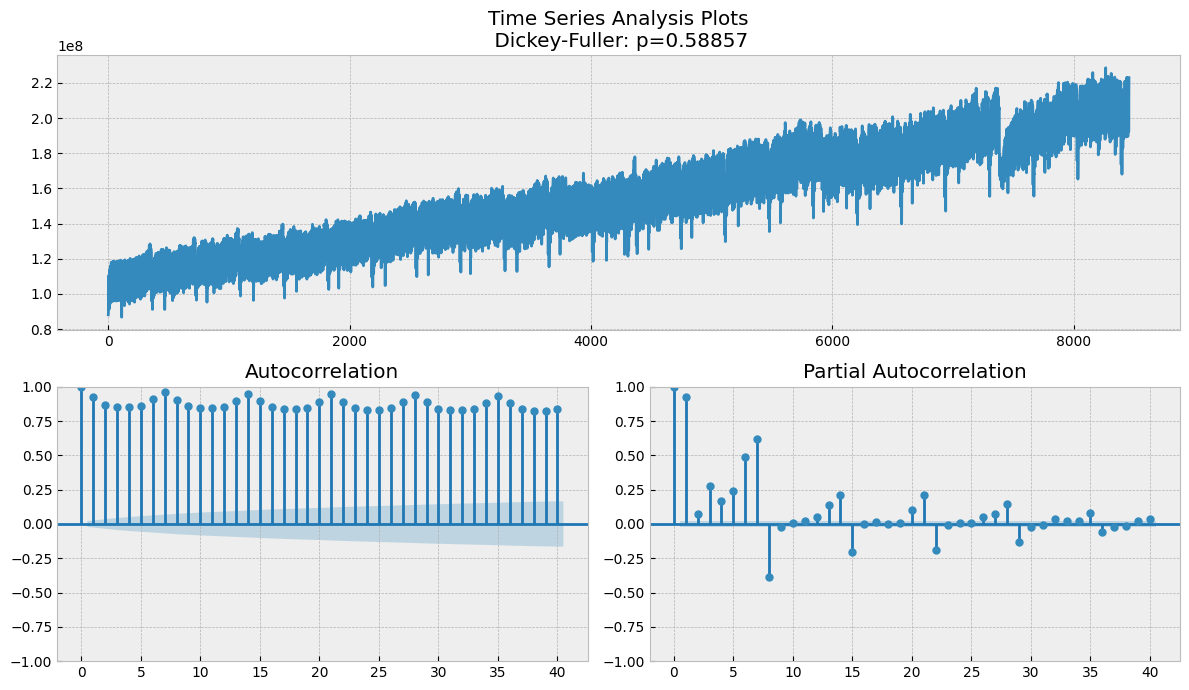

In [12]:
diff_demanda = np.diff(df['demanda'])


tool.demand_utilities.tsplot(df['demanda'])

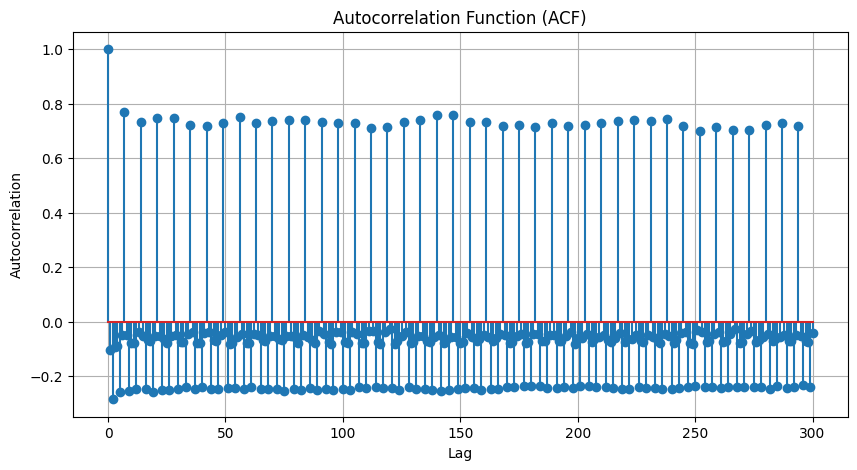

In [13]:
# Calcular la ACF
acf_values = sm.tsa.acf(diff_demanda)
# Calcular la ACF con más lags (por ejemplo, hasta 50)
max_lag = 300
acf_values, confidence_intervals = sm.tsa.acf(diff_demanda, nlags=max_lag, alpha=0.05)
plt.figure(figsize=(10, 5))  # Puedes ajustar el tamaño según tus preferencias
# Graficar la ACF
plt.stem(range(max_lag + 1), acf_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

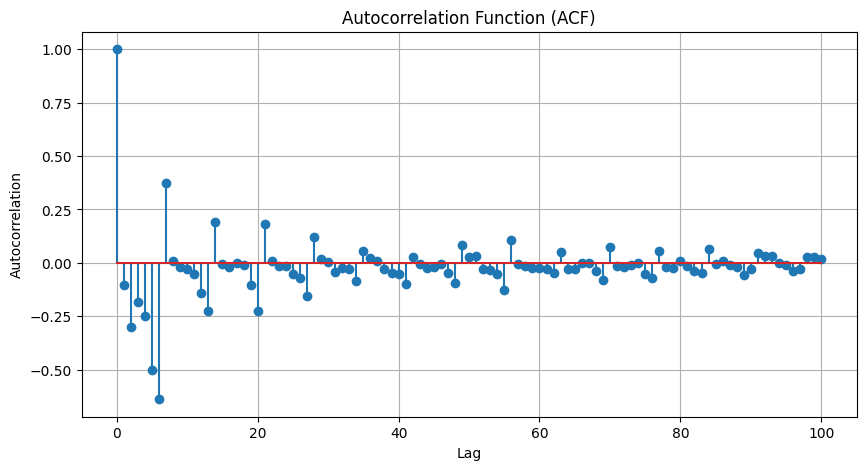

In [14]:
max_lag = 100
acf_values, confidence_intervals = sm.tsa.pacf(diff_demanda, nlags=max_lag, alpha=0.05)
plt.figure(figsize=(10, 5))
# Graficar la ACF
plt.stem(range(max_lag + 1), acf_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(diff_demanda)

result={'adf_statistic': result[0],
                'p_value': result[1],
                'used_lags': result[2],
                'n_observations': result[3],
                'critical_values': result[4]}
result  # ya es estacionaria

{'adf_statistic': -20.63955653943163,
 'p_value': 0.0,
 'used_lags': 37,
 'n_observations': 8421,
 'critical_values': {'1%': -3.4311267835732218,
  '5%': -2.861883285043971,
  '10%': -2.5669527257535725}}

In [16]:
exog=df[['prep','temp']].iloc[1:]
exog.to_numpy()

array([[ 2.771091  , 22.09623397],
       [ 3.76305221, 21.87124902],
       [ 4.02616541, 21.5789185 ],
       ...,
       [ 1.5159228 , 22.56493289],
       [ 2.31622596, 22.70212766],
       [ 4.43806061, 22.73898026]])

In [17]:
model = sm.tsa.statespace.SARIMAX(diff_demanda,order = (0,1,0),seasonal_order = (0,1,0,7),exog=exog.to_numpy())
model_fit = model.fit()
print(model_fit.summary()) # hay indicios de autocorrelación significativa, no normalidad y cierta heterocedasticidad en los residuos

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 8459
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood             -183937.829
Date:                           Fri, 11 Aug 2023   AIC                         367881.658
Time:                                   13:12:48   BIC                         367902.784
Sample:                                        0   HQIC                        367888.870
                                          - 8459                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.078e+04   2.68e+08   7.76e-05      1.000   -5.25e+08    5.25e+08
x2          1.874e+06   1.82e+09      0.001

*l modelo SARIMAX ajustado es bastante complejo y parece tener problemas en términos de autocorrelación en los residuos y la normalidad de los mismos.*

In [9]:
from itertools import product
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

def optimize_SARIMA(y, x, d, D, s, parametros=[3, 3, 3, 3], validacion=12, forecasting_steps=12):
    """
    Esta función calcula múltiples modelos SARIMA y retorna un listado de los parámetros del modelo 
    con mejor desempeño predictivo fuera de muestra en términos del Error Porcentual Absoluto Medio (MAPE). 

    PARÁMETROS:
    y: Variable Endógena
    d: Orden de Integración Regular
    D: Orden de Integración Estacional
    s: Periodicidad o duración de la temporada
    parametros: máximo orden del valor de los parámetros (p, q, P, Q)
    validacion: número de registros para validar el modelo.
    """

    # Cut data: Training and Testing
    y_train = y[:len(y) - validacion]
    y_test = y[len(y) - validacion:]
    x_train = x[:len(y) - validacion]
    x_test = x[len(y) - validacion:]

    # Parameters
    p = range(0, parametros[0] + 1, 1)
    q = range(0, parametros[1] + 1, 1)
    P = range(0, parametros[2] + 1, 1)
    Q = range(0, parametros[3] + 1, 1)
    parameters = product(p, q, P, Q)
    parameters_list = list(parameters)

    results = []

    # Estimate
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(y_train, exog=x_train, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        y_pred = model.forecast(y_test.shape[0], exog=x_test)
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        results.append([param, mape, rmse])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'MAPE', 'RMSE']

    # Sort in ascending order, lower MAPE is better
    result_df = result_df.sort_values(by='MAPE', ascending=True).reset_index(drop=True).iloc[0, :]
    parameters = result_df[0]
    mape = result_df[1]
    rmse = result_df[2]

    # Estimate with all data
    best_model = SARIMAX(y, exog=x, order=(parameters[0], d, parameters[1]),
                         seasonal_order=(parameters[2], D, parameters[3], s)).fit(disp=-1)

    # Forecasting
    forecast = best_model.forecast(steps=forecasting_steps, exog=x_test)

    return {'forecast': forecast, 'parameters': parameters, 'mape': mape, 'rmse': rmse}

In [11]:
y = df['demanda']; x=df[['prep','temp']]; d=1; D=1; s=7; parametros = [3,3,3,3]; validacion = 28; forecasting_steps=28
result_1=tool.modeling.optimize_SARIMA(y, x,  d, D, s, parametros, validacion, forecasting_steps)
result_1

  0%|          | 0/256 [00:00<?, ?it/s]

{'forecast': 8460   221347472.3
 8461   222163413.2
 8462   222265262.6
 8463   212601619.7
 8464   193352874.4
 8465   218685399.6
 8466   222196704.4
 8467   223559331.9
 8468   223897719.2
 8469   224323765.3
 8470   214773675.5
 8471   195991455.8
 8472   221559524.5
 8473   225385329.9
 8474   226139655.4
 8475   225854774.2
 8476   226744510.4
 8477   216235153.4
 8478   197503125.0
 8479   222503080.8
 8480   225799264.3
 8481   225257112.8
 8482   227388135.1
 8483   228007847.1
 8484   218529158.5
 8485   199457080.1
 8486   225452718.7
 8487   229143604.6
 Name: predicted_mean, dtype: float64,
 'parameters': (0, 1, 1, 0),
 'mape': 0.8086550125127154}

In [10]:
y = df['demanda']; x=df[['prep','temp']]; d=1; D=1; s=7; parametros = [2,2,2,2]; validacion = 28; forecasting_steps=28
result_1=tool.modeling.optimize_SARIMA(y, x,  d, D, s, parametros, validacion, forecasting_steps)
result_1

  0%|          | 0/81 [00:00<?, ?it/s]

{'forecast': 8460   221347472.3
 8461   222163413.2
 8462   222265262.6
 8463   212601619.7
 8464   193352874.4
 8465   218685399.6
 8466   222196704.4
 8467   223559331.9
 8468   223897719.2
 8469   224323765.3
 8470   214773675.5
 8471   195991455.8
 8472   221559524.5
 8473   225385329.9
 8474   226139655.4
 8475   225854774.2
 8476   226744510.4
 8477   216235153.4
 8478   197503125.0
 8479   222503080.8
 8480   225799264.3
 8481   225257112.8
 8482   227388135.1
 8483   228007847.1
 8484   218529158.5
 8485   199457080.1
 8486   225452718.7
 8487   229143604.6
 Name: predicted_mean, dtype: float64,
 'parameters': (0, 1, 1, 0),
 'mape': 0.8086550125127154}

In [17]:
y = df['demanda']; x=df[['prep','temp']]; d=1; D=1; s=7; parametros = [5,5,5,5]; validacion = 28; forecasting_steps=28
result_1=tool.modeling.optimize_SARIMA(y, x,  d, D, s, parametros, validacion, forecasting_steps)
result_1

  0%|          | 0/1296 [00:00<?, ?it/s]

{'forecast': 2023-03-01   222386299.0
 2023-03-02   222868393.8
 2023-03-03   224120223.7
 2023-03-04   215874697.1
 2023-03-05   197361950.1
 2023-03-06   220123610.6
 2023-03-07   226145208.6
 2023-03-08   227526073.7
 2023-03-09   227302113.6
 2023-03-10   228454797.4
 2023-03-11   219438061.9
 2023-03-12   200661912.5
 2023-03-13   222924409.1
 2023-03-14   229019523.4
 2023-03-15   230302423.9
 2023-03-16   229352391.0
 2023-03-17   229983256.3
 2023-03-18   219921446.6
 2023-03-19   201540630.8
 2023-03-20   224500579.9
 2023-03-21   229003998.3
 2023-03-22   228935344.7
 2023-03-23   229752052.5
 2023-03-24   230813211.4
 2023-03-25   221436752.9
 2023-03-26   202490714.8
 2023-03-27   224918133.1
 2023-03-28   231444866.2
 Freq: D, Name: predicted_mean, dtype: float64,
 'parameters': (2, 5, 4, 4),
 'mape': 0.8238921974717468}

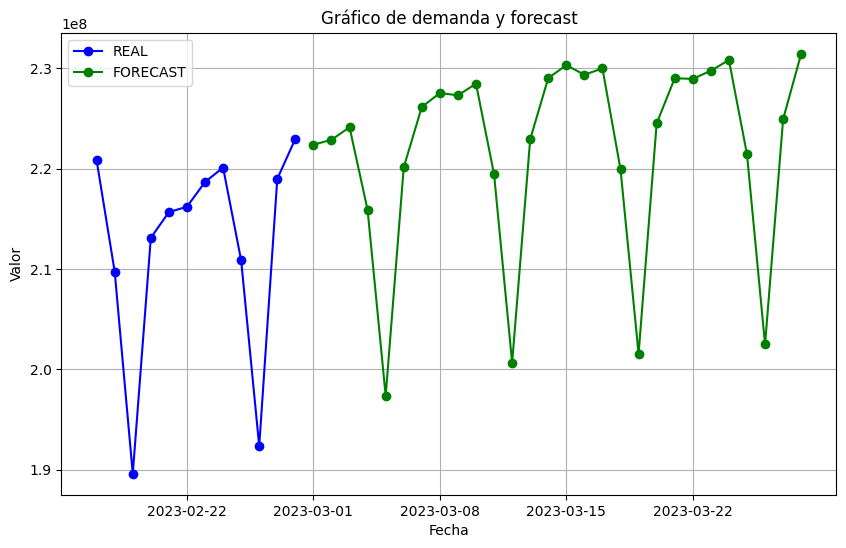

In [20]:
# Ejemplo de uso:
plot_two_time_series(df['demanda'].iloc[-12:], result_1['forecast'], title='Gráfico de demanda y forecast', x_label='Fecha', y_label='Valor', color_real='blue', color_forecast='green', marker_type='o')


In [16]:
y = df['demanda']; x=df[['prep','temp']]; d=1; D=1; s=7; parametros = [4,4,4,4]; validacion = 28; forecasting_steps=28
result=tool.modeling.optimize_SARIMA(y, x,  d, D, s, parametros, validacion, forecasting_steps)
result

  0%|          | 0/625 [00:00<?, ?it/s]

{'forecast': 2023-03-01   222863146.0
 2023-03-02   223003365.2
 2023-03-03   224486246.3
 2023-03-04   216085158.2
 2023-03-05   197658765.4
 2023-03-06   221282194.9
 2023-03-07   226513624.8
 2023-03-08   228137671.7
 2023-03-09   227732952.8
 2023-03-10   229070741.5
 2023-03-11   219623879.9
 2023-03-12   201053860.4
 2023-03-13   223920633.6
 2023-03-14   229415418.3
 2023-03-15   230516769.2
 2023-03-16   229814068.5
 2023-03-17   230472409.3
 2023-03-18   219998344.2
 2023-03-19   201186075.6
 2023-03-20   223256657.5
 2023-03-21   228681151.5
 2023-03-22   228783787.4
 2023-03-23   229533079.1
 2023-03-24   230485659.4
 2023-03-25   221601304.2
 2023-03-26   202306111.3
 2023-03-27   224194982.7
 2023-03-28   231160584.2
 Freq: D, Name: predicted_mean, dtype: float64,
 'parameters': (0, 1, 4, 4),
 'mape': 0.865044271961966}

In [5]:
y = df['demanda']; x=df['prep']; d=1; D=1; s=7; parametros = [4,4,4,4]; validacion = 12; forecasting_steps=12
result=tool.modeling.optimize_SARIMA(y, x,  d, D, s, parametros, validacion, forecasting_steps)
result

  0%|          | 0/625 [00:00<?, ?it/s]

{'forecast': 2023-03-01   223886292.02
 2023-03-02   224536861.51
 2023-03-03   225959250.33
 2023-03-04   217376151.91
 2023-03-05   198911631.32
 2023-03-06   222628765.76
 2023-03-07   227619660.02
 2023-03-08   228460799.95
 2023-03-09   228947608.16
 2023-03-10   230246696.79
 2023-03-11   221097213.40
 2023-03-12   202534965.54
 Freq: D, Name: predicted_mean, dtype: float64,
 'parameters': (1, 2, 4, 4),
 'mape': 1.182029065799997}

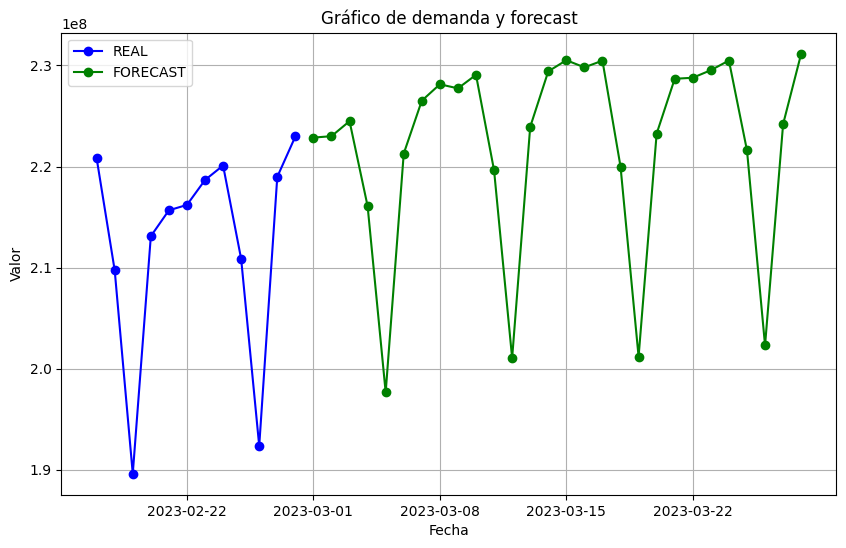

In [19]:
import matplotlib.pyplot as plt

def plot_two_time_series(df_demand, df_forecast, title='Gráfico de dos series de tiempo', x_label='Fecha', y_label='Valor', color_real='blue', color_forecast='green', marker_type='o', figsize=(10, 6)):
    # Crea la figura y agrega las dos series de tiempo
    plt.figure(figsize=figsize)
    # Serie de tiempo REAL
    plt.plot(df_demand.index, df_demand.values, label='REAL', color=color_real, marker=marker_type)
    # Serie de tiempo FORECAST
    plt.plot(df_forecast.index, df_forecast.values, label='FORECAST', color=color_forecast, marker=marker_type)
    # Personalizar el gráfico (títulos, etiquetas, leyenda, etc.)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso:
plot_two_time_series(df['demanda'].iloc[-12:], result['forecast'], title='Gráfico de demanda y forecast', x_label='Fecha', y_label='Valor', color_real='blue', color_forecast='green', marker_type='o')


In [25]:
y = df['demanda']; x=df['prep']; d=1; D=1; s=7; parametros = [3,3,3,3]; validacion = 12; forecasting_steps=12
result = optimize_SARIMA(y, x,  d, D, s, parametros, validacion, forecasting_steps)
result

  0%|          | 0/256 [00:00<?, ?it/s]

{'forecast': 2023-03-01   223794686.02
 2023-03-02   225410910.29
 2023-03-03   226294291.22
 2023-03-04   217200125.29
 2023-03-05   198784735.44
 2023-03-06   224202724.78
 2023-03-07   227779054.05
 2023-03-08   228306241.53
 2023-03-09   229682639.46
 2023-03-10   230434912.15
 2023-03-11   221214899.75
 2023-03-12   202525496.88
 Freq: D, Name: predicted_mean, dtype: float64,
 'parameters': (3, 3, 2, 0),
 'mape': 1.2850295671579244}

In [10]:
y = df['demanda']; d=1; D=1; s=7; parametros = [3,3,3,3]; validacion = 12; forecasting_steps=12
result = optimize_SARIMA(y, d, D, s, parametros, validacion, forecasting_steps)
result

  0%|          | 0/256 [00:00<?, ?it/s]

{'forecast': 2023-03-01   223525192.22
 2023-03-02   225280294.21
 2023-03-03   226164357.57
 2023-03-04   217008717.64
 2023-03-05   198513180.57
 2023-03-06   224158699.95
 2023-03-07   227831130.43
 2023-03-08   228221767.35
 2023-03-09   229605692.84
 2023-03-10   230360780.63
 2023-03-11   221058662.10
 2023-03-12   202319792.33
 Freq: D, Name: predicted_mean, dtype: float64,
 'parameters': (3, 3, 2, 0),
 'mape': 1.334631364148333}

In [9]:
y = df['demanda']; d=1; D=1; s=7; parametros = [2,6,1,2]; validacion = 12; forecasting_steps=12
result = optimize_SARIMA(y, d, D, s, parametros, validacion, forecasting_steps)
result


#MAPE: En promedio, las predicciones del modelo difieren en aproximadamente un 1.31% de los valores reales 'parameters': (2, 4, 1, 0)

  0%|          | 0/126 [00:00<?, ?it/s]

{'forecast': 2023-03-01   223924812.63
 2023-03-02   225680099.89
 2023-03-03   226307845.36
 2023-03-04   216567417.94
 2023-03-05   198017372.05
 2023-03-06   224597026.32
 2023-03-07   228631883.79
 2023-03-08   229394904.88
 2023-03-09   230890520.81
 2023-03-10   231388257.58
 2023-03-11   221807426.30
 2023-03-12   203582702.23
 Freq: D, Name: predicted_mean, dtype: float64,
 'parameters': (2, 4, 1, 0),
 'mape': 1.3084652462270951}

### Transformación Yeo Johnson

In [5]:
df_yeo=tool.modeling.yeo_johnson_test(df)

Columna demanda: lambda=0.60. Transformada con éxito.
Columna prep: lambda=0.29. Se recomienda la transformación logarítmica.
Columna temp: lambda=-0.80. Se recomienda la transformación logarítmica.


In [6]:
df_yeo.describe()

,demanda,prep,temp
count,8460.0,8460.0,8460.0
mean,144755.2,2.5,1.1
std,16823.1,0.9,0.0
min,100564.4,0.2,1.1
25%,130458.2,1.9,1.1
50%,144483.1,2.5,1.1
75%,158978.0,3.1,1.1
max,180236.9,5.3,1.2


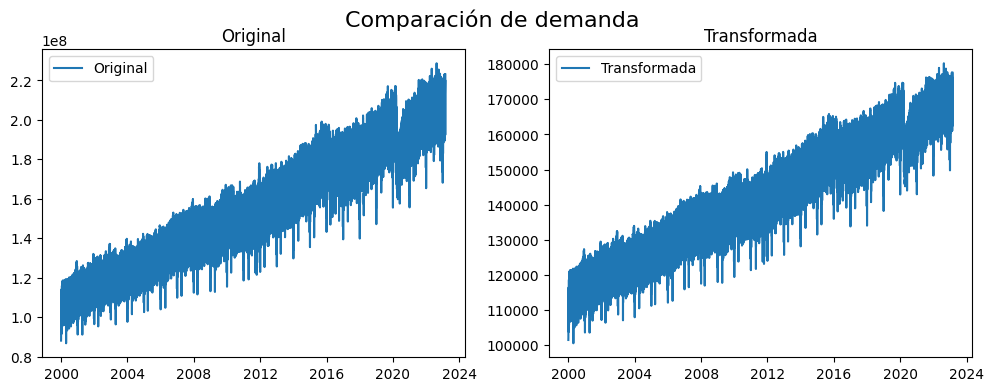

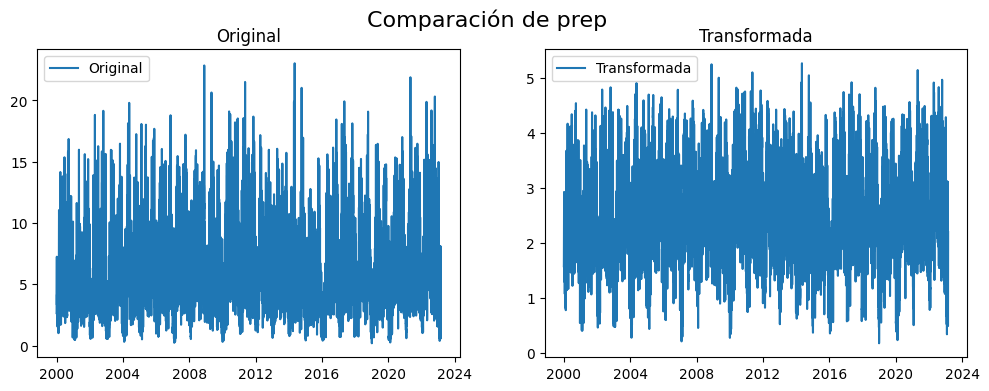

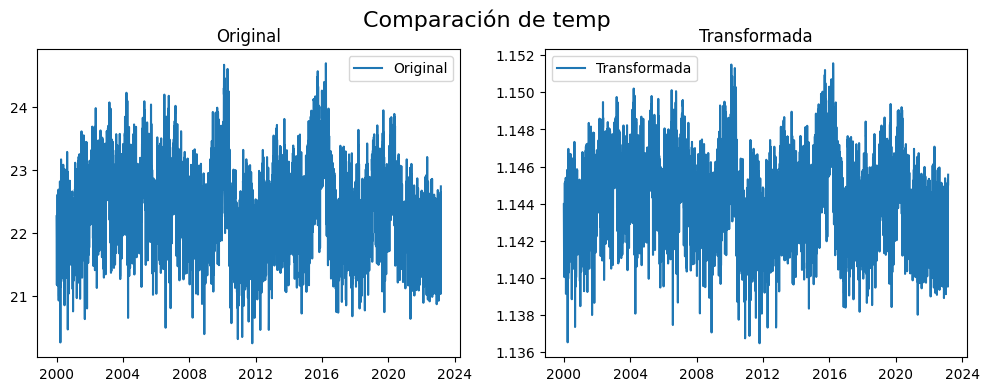

In [7]:
tool.modeling.plot_comparison(df, df_yeo)

## MODELING

                            OLS Regression Results                            
Dep. Variable:                demanda   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     36.10
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           2.44e-16
Time:                        21:05:07   Log-Likelihood:            -1.5779e+05
No. Observations:                8460   AIC:                         3.156e+05
Df Residuals:                    8457   BIC:                         3.156e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.55e+08   1.32e+07     19.376      0.0

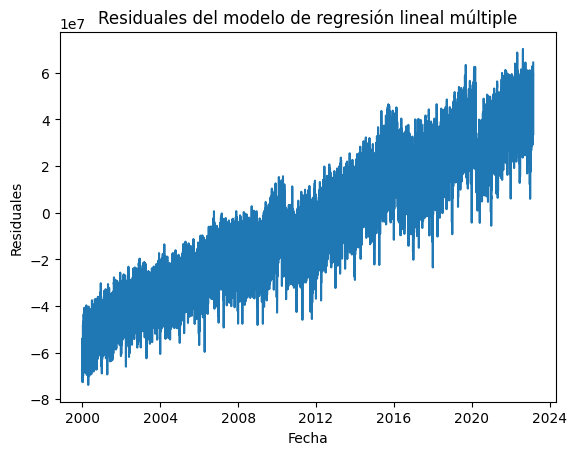

In [124]:
# Leer los datos de la demanda de energía en Colombia

# Realizar el modelo de regresión lineal múltiple con las covariables
model = sm.OLS(df['demanda'], sm.add_constant(df[['temp', 'prep']]))

# Ajustar el modelo a los datos y obtener los resultados
results = model.fit()

# Imprimir los resultados de la regresión
print(results.summary())

# Graficar los residuales del modelo
plt.plot(results.resid)
plt.xlabel('Fecha')
plt.ylabel('Residuales')
plt.title('Residuales del modelo de regresión lineal múltiple')
plt.show()

*En resumen, el modelo parece tener un R-cuadrado bajo, lo que sugiere que las variables independientes (temp y prep) no están explicando mucha variación en la variable dependiente (demanda). Además, algunos de los coeficientes no son estadísticamente significativos (P>|t| > 0.05), lo que indica que no se puede afirmar que tengan un efecto significativo en la variable dependiente. Por otro lado, el estadístico de Omnibus y la prueba de Jarque-Bera sugieren que los residuos pueden no estar siguiendo una distribución normal, lo que podría ser una preocupación para la validez del modelo. Sería importante realizar un análisis más detallado de los residuos y evaluar otras métricas de ajuste para determinar la calidad del modelo.*

### HOLT WINTER

In [73]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Calcular el número de registros que representan el 20% de la serie para el conjunto de prueba
num_test_samples = int(len(df_yeo) * 0.2)

# Split train and test
train = df_yeo.iloc[:-num_test_samples]
test = df_yeo.iloc[-num_test_samples:]

# view
print(f"Training Sample Size: {train.shape[0]} | Testing Sample Size: {test.shape[0]}")

train.reset_index(inplace=True)
test.reset_index(inplace=True)

Training Sample Size: 6768 | Testing Sample Size: 1692


In [110]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go

# Crear los subplots
fig = make_subplots(rows=1, cols=1)

# Agregar la serie de tiempo de entrenamiento al gráfico
fig.add_trace(go.Scatter(x=train.index, y=train['demanda'], mode='lines', name='train'))

# Agregar la serie de tiempo de prueba al gráfico
fig.add_trace(go.Scatter(x=test.index, y=test['demanda'], mode='lines', name='test'))

# Configurar el diseño del gráfico
fig.update_layout(
    title='Datos de entrenamiento y prueba',
    xaxis_title='Fecha',
    yaxis_title='Demanda',
    showlegend=True,
    margin=dict(l=50, r=20, t=50, b=50),
    hovermode='x'
)



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines',
              'name': 'train',
              'type': 'scatter',
              'x': array([datetime.datetime(2000, 1, 1, 0, 0),
                          datetime.datetime(2000, 1, 2, 0, 0),
                          datetime.datetime(2000, 1, 3, 0, 0), ...,
                          datetime.datetime(2018, 7, 10, 0, 0),
                          datetime.datetime(2018, 7, 11, 0, 0),
                          datetime.datetime(2018, 7, 12, 0, 0)], dtype=object),
              'y': array([101502.28080776, 102182.3882607 , 113554.52262721, ..., 166325.57983526,
                          166221.49758777, 167374.65051981])},
             {'mode': 'lines',
              'name': 'test',
              'type': 'scatter',
              'x': array([datetime.datetime(2018, 7, 13, 0, 0),
                          datetime.datetime(2018, 7, 14, 0, 0),
                          datetime.datetime(2018, 7, 15, 0, 0), ...,
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 2, 27, 0, 0),
                          datetime.datetime(2023, 2, 28, 0, 0)], dtype=object),
              'y': array([168097.73413774, 162729.54398504, 153361.50301069, ..., 162429.85959969,
                          175618.83925488, 177540.8089837 ])}],
    'layout': {'hovermode': 'x',
               'margin': {'b': 50, 'l': 50, 'r': 20, 't': 50},
               'showlegend': True,
               'template': '...',
               'title': {'text': 'Datos de entrenamiento y prueba'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Fecha'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Demanda'}}}
})

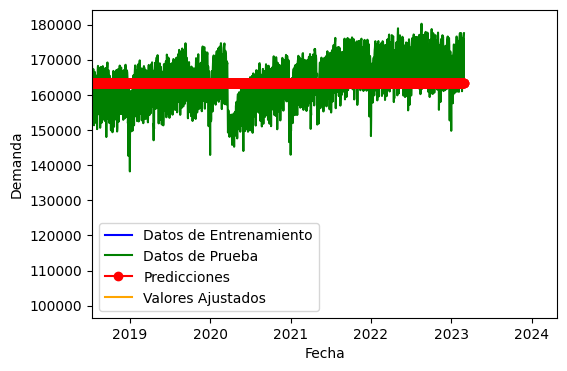

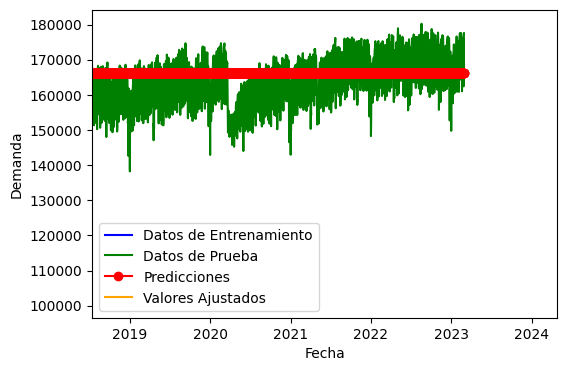

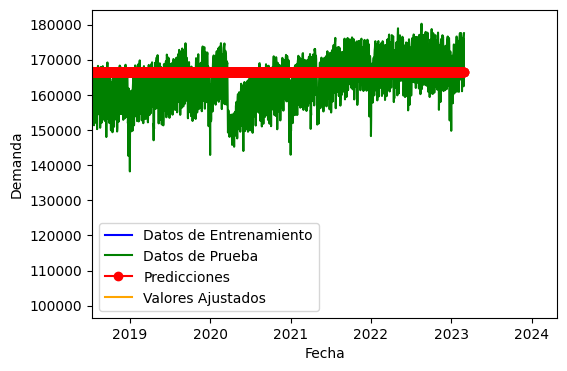

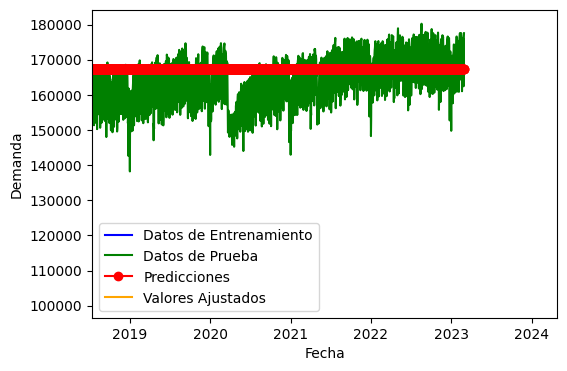

MAPE para cada valor de alpha_sm:
alpha = 0.2: 3.93%
alpha = 0.5: 3.48%
alpha = 0.6: 3.45%
alpha = 0.9: 3.44%


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing

# Calcular el número de registros que representan el 20% de la serie para el conjunto de prueba
num_test_samples = int(len(df_yeo) * 0.2)

# Dividir los datos en conjuntos de entrenamiento y prueba
train = df_yeo.iloc[:-num_test_samples]
test = df_yeo.iloc[-num_test_samples:]

# Definir los valores de alpha_sm para probar
alpha_values = [0.2, 0.5, 0.6, 0.9]

# Inicializar una lista para almacenar los MAPE de cada iteración
mape_values = []

# Iterar sobre los diferentes valores de alpha_sm
for alpha_sm in alpha_values:
    # Ajustar el modelo y obtener las predicciones para el conjunto de prueba
    fit1 = SimpleExpSmoothing(train['demanda']).fit(smoothing_level=alpha_sm, optimized=False)
    fcast1 = fit1.forecast(len(test['demanda'])).rename('alpha = ' + str(alpha_sm))

    # Calcular el MAPE para este valor de alpha_sm
    actual_values = test['demanda']
    mape = (np.abs(actual_values - fcast1.values) / actual_values).mean() * 100
    mape_values.append(mape)

    # Graficar las predicciones, los valores ajustados y los datos de entrenamiento y prueba
    plt.figure(figsize=(6, 4))
    plt.plot(train.index, train['demanda'], label='Datos de Entrenamiento', color='blue')
    plt.plot(test.index, test['demanda'], label='Datos de Prueba', color='green')
    plt.plot(fcast1.index, fcast1, label='Predicciones', color='red', marker='o')
    plt.plot(fit1.fittedvalues.index, fit1.fittedvalues, label='Valores Ajustados', color='orange')

    # Establecer el límite inferior del eje x a partir de 2018-07-13
    plt.xlim(pd.Timestamp('2018-07-13'), None)

    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

# Imprimir los MAPE de cada iteración
print("MAPE para cada valor de alpha_sm:")
for i in range(len(alpha_values)):
    print("alpha = {}: {:.2f}%".format(alpha_values[i], mape_values[i]))


In [51]:
# Definir los hiperparámetros que deseas probar
seasonal_options = ['add', 'mul', 'additive', 'multiplicative', None]
trend_options = ['add', 'mul', 'additive', 'multiplicative', None]
smoothing_level_options = [0.1, 0.2, 0.3, 0.4, 0.5]

# Inicializar variables para guardar los mejores hiperparámetros y el mejor rendimiento
best_mse = float('inf')
best_params = {}

# Realizar la búsqueda de hiperparámetros iterando sobre todas las combinaciones
for seasonal in seasonal_options:
    for trend in trend_options:
        for smoothing_level in smoothing_level_options:
            # Crear y ajustar el modelo para cada combinación de hiperparámetros
            model = ExponentialSmoothing(train['demanda'], seasonal=seasonal, trend=trend, seasonal_periods=7)
            fit_model = model.fit(smoothing_level=smoothing_level)

            # Calcular el rendimiento utilizando MSE (u otra métrica)
            mse = ((fit_model.fittedvalues - test['demanda']) ** 2).mean()
            mape = (np.abs(test['demanda'] - fit_model.fittedvalues) / test['demanda']).mean() * 100

            # Actualizar los mejores hiperparámetros si el rendimiento es mejor
            if mse < best_mse:
                best_mse = mse
                best_params = {
                    'seasonal': seasonal,
                    'trend': trend,
                    'smoothing_level': smoothing_level
                }

# Imprimir los mejores hiperparámetros y el mejor rendimiento
print("Mejores hiperparámetros:")
print(best_params)

print("\nMejor MSE:")
print(best_mse)

print("\nMejor MAPE:")
print(mape)

Mejores hiperparámetros:
{'seasonal': None, 'trend': 'mul', 'smoothing_level': 0.1}

Mejor MSE:
1909811024.6347692

Mejor MAPE:
26.12918679782111


In [53]:

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import numpy as np


# Define el parámetro de suavizado (alpha)
smoothing_level = 0.3
optimized=True
remove_bias=True
method="L-BFGS-B"

# Fit simple model and get forecasts
model_holt = Holt(train['demanda'], damped_trend=True).fit(smoothing_level=smoothing_level, optimized=optimized,remove_bias=remove_bias, method=method)
# Realizar predicciones para el conjunto de pruebas
forecasts_holt = model_holt.forecast(len(test))


# Fit Holt Winters model and get forecasts
model_holt_winters = ExponentialSmoothing(train['demanda'], trend='mul',
                                          seasonal='mul', seasonal_periods=7)\
                                          .fit(smoothing_level=smoothing_level, optimized=optimized,remove_bias=remove_bias, method=method)
forecasts_holt_winters = model_holt_winters.forecast(len(test))




# Calcular el MAE (Mean Absolute Error)
actual_values=test['demanda'].values
predicted_values=forecasts_holt_winters.values

mae = np.mean(np.abs(actual_values - predicted_values))

# Calcular el MSE (Mean Squared Error)
mse = np.mean((actual_values - predicted_values)**2)

# Calcular el RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Calcular el MAPE (Mean Absolute Percentage Error)
def calculate_mape(actual, predicted):
    mask = actual != 0
    return np.mean(np.abs((actual - predicted) / actual[mask])) * 100

mape = calculate_mape(actual_values, predicted_values)

# Calcular el MPE (Mean Percentage Error)
mpe = np.mean((actual_values - predicted_values) / actual_values) * 100

# Calcular Theil's U
theil_u = np.sqrt(np.mean((actual_values - predicted_values)**2)) / np.sqrt(np.mean(actual_values**2))

# Calcular MASE (Mean Absolute Scaled Error)
def calculate_mase(actual, predicted):
    naive_forecast = np.roll(actual, 1)
    naive_forecast[0] = actual[0]
    return np.mean(np.abs(actual - predicted)) / np.mean(np.abs(actual - naive_forecast))

mase = calculate_mase(actual_values, predicted_values)

# Calcular Theil's Inequality Coefficient
theil_inequality = np.sqrt(np.mean((actual_values - predicted_values)**2)) / np.sqrt(np.mean(actual_values**2 - np.roll(actual_values, 1)**2))

# Imprimir resultados
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MPE: {mpe:.2f}%")
print(f"Theil's U: {theil_u:.2f}")
print(f"MASE: {mase:.2f}")
print(f"Theil's Inequality Coefficient: {theil_inequality:.2f}")

MAPE: 2.04%
MAE: 3307.67
MSE: 23159500.99
RMSE: 4812.43
MPE: -0.51%
Theil's U: 0.03
MASE: 0.75
Theil's Inequality Coefficient: inf


In [127]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
print(f'Mean Absolute Error = {mean_absolute_error(actual_values,predicted_values)}')
print(f'Mean Squared Error = {mean_squared_error(actual_values,predicted_values)}')
print(f'Mean Absolute Percentage  Error = {mean_absolute_percentage_error(actual_values,predicted_values)}')

Mean Absolute Error = 3307.66849165695
Mean Squared Error = 23159500.98591828
Mean Absolute Percentage  Error = 0.020387089388005653


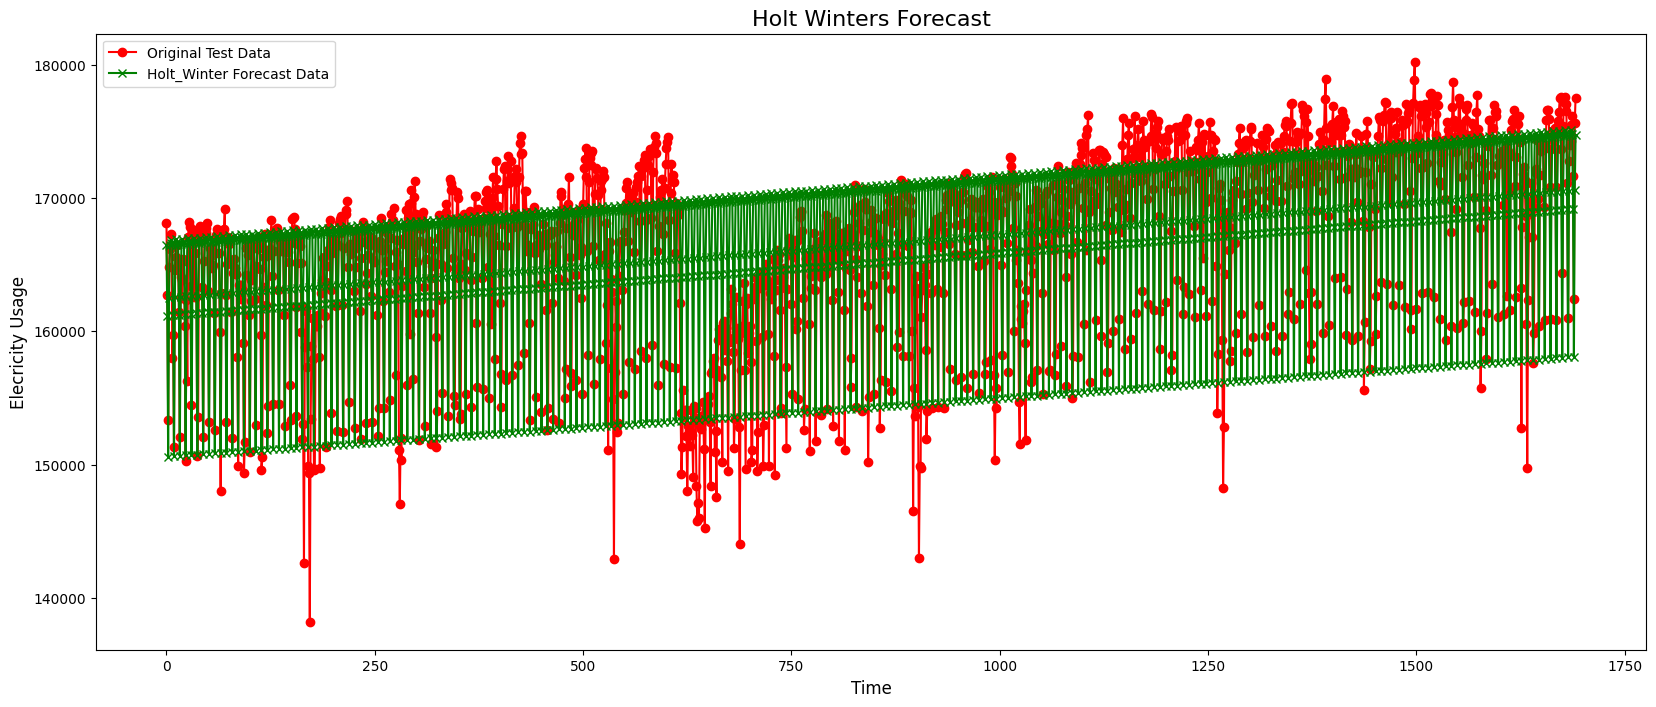

In [68]:
plt.figure(figsize=(20,8))

#plt.plot(train.index, train['demanda'], "b.-", label='Train Data')
plt.plot(test.index, test['demanda'], "ro-", label='Original Test Data')
plt.plot(test.index, forecasts_holt_winters, "gx-", label='Holt_Winter Forecast Data')
plt.ylabel('Elecricity Usage', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='best')
plt.title('Holt Winters Forecast', fontsize=16)
plt.show()

In [86]:
print(model_holt_winters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  demanda   No. Observations:                 6768
Model:             ExponentialSmoothing   SSE                    68073921119.181
Optimized:                         True   AIC                         109148.549
Trend:                   Multiplicative   BIC                         109223.569
Seasonal:                Multiplicative   AICC                        109148.603
Seasonal Periods:                     7   Date:                 Sun, 23 Jul 2023
Box-Cox:                          False   Time:                         18:35:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5353571                alpha                 True
smoothing_trend          

### Skforecast

In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Calcular el número de registros que representan el 20% de la serie para el conjunto de prueba
num_test_samples = int(len(df) * 0.2)

# Split train and test
train = df.iloc[:-num_test_samples]
test = df.iloc[-num_test_samples:]

# view
print(f"Training Sample Size: {train.shape[0]} | Testing Sample Size: {test.shape[0]}")

train.reset_index(inplace=True)
test.reset_index(inplace=True)

Training Sample Size: 6768 | Testing Sample Size: 1692


In [9]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar forecaster
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=train['demanda'])

In [18]:
# Predicciones
# ==============================================================================
steps = len(test)
predicciones = forecaster.predict(steps=steps)

In [22]:
fechas = pd.date_range(start='2018-07-13', end='2023-02-28', freq='D')
# Crear el DataFrame con las dos columnas
df_predicciones = pd.DataFrame({'Fecha': fechas, 'predicciones': predicciones}).set_index('Fecha')

In [23]:
from sklearn.metrics import mean_squared_error
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['demanda'],
                y_pred = df_predicciones['predicciones']
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 4678591231705979.0


In [24]:
# Grid search de hiperparámetros
# ==============================================================================
steps = len(test)

# Crear forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

# Lags utilizados como predictores
lags_grid = [10, 36]

# Hiperparámetros del regresor
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}


resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['demanda'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 24.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 10
[LightGBM] [Info] Start training from score 130923188.810907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

lags grid:  50%|█████     | 1/2 [00:50<00:50, 50.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 3348, number of used features: 36
[LightGBM] [Info] Start training from score 131069171.868578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 3348, number of used features: 36
[LightGBM] [Info] Start training from score 131069171.868578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

lags grid: 100%|██████████| 2/2 [01:29<00:00, 44.98s/it]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 6732, number of used features: 36
[LightGBM] [Info] Start training from score 150259478.262626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [25]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}",481753975886566.2,0.0,5.0,500.0
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",580731983517105.2,0.1,3.0,100.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}",702636274834395.5,0.1,5.0,100.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",739551616238861.6,0.0,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",828723446444635.4,0.1,3.0,100.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",885823408913093.5,0.0,3.0,500.0
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}",948692703082357.2,0.0,10.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}",1203926625706859.5,0.1,10.0,100.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}",1258927251781105.5,0.0,3.0,100.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}",1275902724448050.5,0.0,5.0,500.0


In [26]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]
# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['demanda'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=train['demanda'])


# Predicciones
# ==============================================================================
steps=36
predicciones = forecaster.predict(steps=steps)


from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.18f}'.format
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test['demanda'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [12:43<00:00, 381.82s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 317537425925277.2



ValueError: Found input variables with inconsistent numbers of samples: [1692, 36]